# Predicción de resultados de un lanzamiento de béisbol

Con los datos del lanzamiento y el contexto del juego, el objetivo es predecir el resultado de un lanzamiento.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

%matplotlib inline

## 1. Carga de datos.


Cargamos los datos originales para acceder a la columna objetivo (type o description), porque en el set de datos limpio no se encuentra.

In [2]:
# Definir columnas de interés
features = [
    # Ubicación
    'plate_x', 'plate_z', 'zone',
    # Física
    'release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate', 
    # Contexto
    'balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b',
    # Categóricas
    'stand', 'p_throws', 'pitch_type'
]

target = 'type'  # B = Ball, S = Strike, X = In Play

# Cargar datos (ajusta las rutas si es necesario)
try:
    df_2023 = pd.read_csv('../data/statcast_raw_data/statcast_2023.csv', usecols=features + [target])
    df_2024 = pd.read_csv('../data/statcast_raw_data/statcast_2024.csv', usecols=features + [target])
    df = pd.concat([df_2023, df_2024], axis=0)
    print(f"Datos cargados: {df.shape}")
except FileNotFoundError:
    print("No se encontraron los archivos raw. Intentando cargar desde clean data (si tuviera target)...")
    # Fallback logic or error message


Datos cargados: (1534286, 17)


## 2. Preprocesamiento
Limpiamos los datos, manejamos valores nulos y codificamos variables categóricas.

In [3]:
# Eliminar filas sin target
df = df.dropna(subset=[target])

# Manejo de valores nulos en features
# Para variables numéricas, usamos la media o mediana
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Para variables categóricas, llenamos con 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Codificación de variables categóricas
le = LabelEncoder()
for col in cat_cols:
    if col != target:
        df[col] = le.fit_transform(df[col].astype(str))

print("Datos preprocesados:")
print(df.head())

Datos preprocesados:
   pitch_type  release_speed  zone  stand  p_throws type  balls  strikes  \
0           2           84.9   1.0      0         1    S    2.0      2.0   
1           6           96.6  14.0      0         1    B    1.0      2.0   
2           2           84.5   1.0      0         1    S    1.0      1.0   
3           6           95.4   2.0      0         1    S    1.0      0.0   
4           6           95.6  14.0      0         1    B    0.0      0.0   

   pfx_x  pfx_z  plate_x  plate_z     on_3b     on_2b     on_1b  outs_when_up  \
0   1.14  -0.90    -0.54     3.55  663457.0  663538.0  661531.0           2.0   
1  -0.35   1.45     0.87     1.76  663457.0  663538.0  661531.0           2.0   
2   1.06  -0.87    -0.58     3.32  663457.0  663538.0  661531.0           2.0   
3  -0.63   1.56     0.16     3.34  663457.0  663538.0  661531.0           2.0   
4  -0.14   1.67     0.42     1.60  663457.0  663538.0  661531.0           2.0   

   release_spin_rate  
0           

## 3. División de datos (Train/Test)

In [4]:
X = df[features]
y = df[target]

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1227428, 16)
Test shape: (306858, 16)


## 4. Entrenamiento del modelo
Como los datos no son lineales y necesitamos la capicidad de manejar estas relacionales, implementamos un `RandomForestClassifier`

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. Evaluación
Revisamos las métricas de precisión, recall y f1-score.

Accuracy: 0.7075585449947532

Classification Report:

              precision    recall  f1-score   support

           B       0.79      0.86      0.83    110594
           S       0.67      0.80      0.73    142340
           X       0.48      0.14      0.22     53924

    accuracy                           0.71    306858
   macro avg       0.65      0.60      0.59    306858
weighted avg       0.68      0.71      0.67    306858



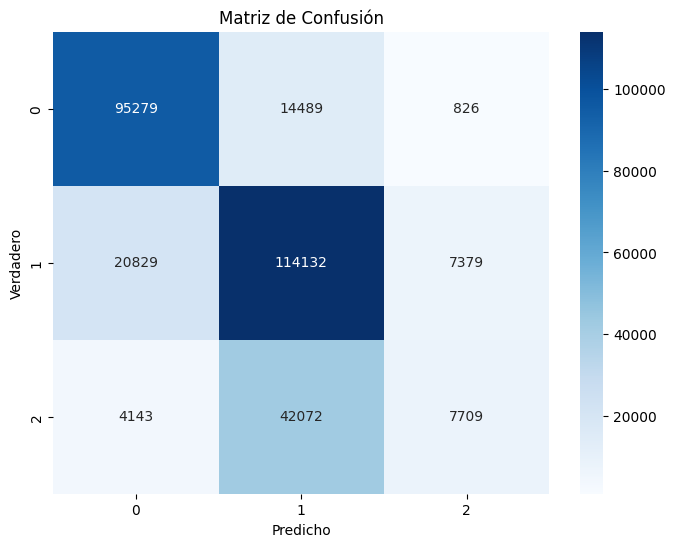

In [6]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

## 6. Importancia de las variables
Ahora con todo lo anterior, podemos hacer predicciones y evaluar el desempeño del modelo.

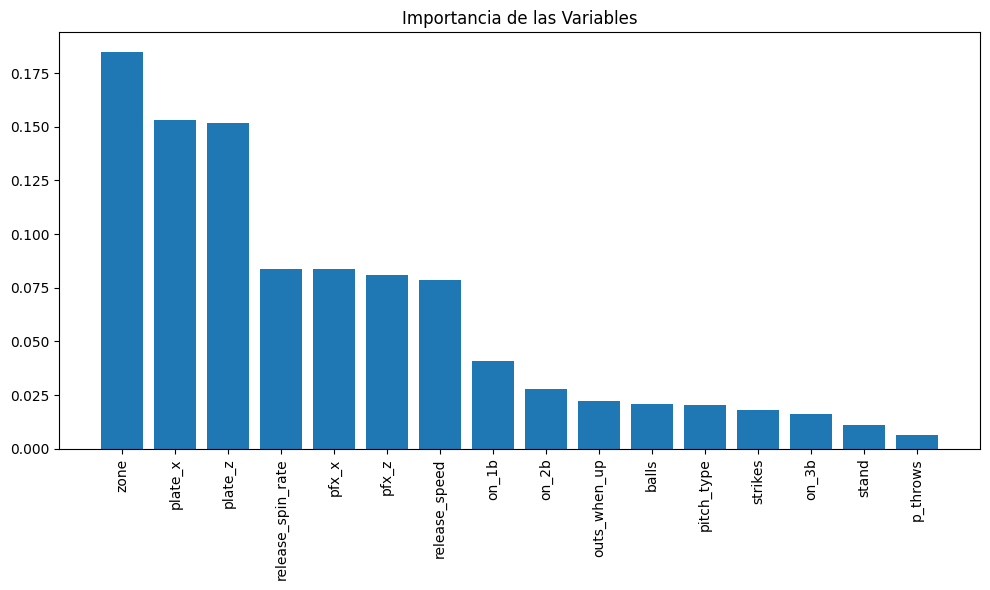

In [7]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las Variables")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()